# Working with Large Point Clouds 
This notebook will explain how use PyForestScan with large data sets. Code snippets for how to get started using PyForestScan or calculate key forest metrics can be found in the notebooks getting-started-importing-preprocessing-dtm-chm or calculate-forest-metrics, and in the documentation. 

We will use a larger section of our example data set. This section contains 2.35 billion points (20GB) with a nominal pulse spacing of 0.35 meters covering the Puuwaawaa reigion of the Big Island of Hawaii. The vegetation here is dry forest and we will clip to the same region as our other examples. This data is hosted on AWS, and can be read directly from AWS, but data can be stored and read locally.

First we will load the necessary python packages and functions.

In [4]:
import geopandas as gpd
import numpy as np

from pyforestscan.handlers import read_lidar, create_geotiff, write_las
from pyforestscan.visualize import plot_metric, plot_2d
from pyforestscan.calculate import assign_voxels, calculate_pad, calculate_pai, calculate_fhd, calculate_chm
from pyforestscan.process import process_with_tiles

## Import Data
PyForestScan leverages PDAL and Entwine to read EPT and COPC data formats. EPT and COPC are optimized for handling very large point clouds and have spatial knowlege of the data, allowing us to access metadata for the entire dataset while working with extracts. We will use this to extract only points that fit within the one kilometer tile that we explored in the other examples. 

In [ ]:
bounds = ([202000.000, 203000.000], [2187999.980, 2189000.000]) #([xmin, xmax], [ymin, ymax])
ept = "https://puuwaawa-ept.s3.us-west-1.amazonaws.com/ept/ept.json"
ept_srs = "EPSG:32605"
pointclouds = read_lidar(ept, ept_srs, bounds, hag=True)

In [ ]:
pointclouds[0]['HeightAboveGround'].max()

In [7]:
voxel_resolution = (5, 5, 1) 
voxels, extent = assign_voxels(pointclouds[0], voxel_resolution)

In [8]:
pad = calculate_pad(voxels, voxel_resolution[-1])
pai = calculate_pai(pad)

In [9]:
np.max(pai)

np.float64(6.098074282166241)

In [10]:
create_geotiff(pai, "data/20191210_5QKB020880_DS05_pai_5m_1m.tif", "EPSG:32605", extent)

In [2]:
from pyforestscan.process import process_with_tiles
process_with_tiles("/Users/iosefa/repos/PyForestScan/data/ept2/ept.json", (200, 200), "/Users/iosefa/repos/PyForestScan/data/tiles", "pai", (5, 5, 1), buffer_size=0.15, srs="EPSG:32605", hag_dtm=True, dtm="data/20191210_5QKB020880_dtm.tif")

Processing tiles: 100%|██████████| 36/36 [01:43<00:00,  2.87s/it]

In [ ]:
### Create DTM

In [51]:
file_path = "../test_data/20191210_5QKB020880_DS05.copc.laz"
file_path = "/Users/iosefa/Desktop/test.las"

In [52]:
arrays = read_lidar(file_path, "EPSG:32605", hag=False)

In [53]:
pointcloud = arrays[0]

In [57]:
pointcloud.dtype

dtype([('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('Synthetic', 'u1'), ('KeyPoint', 'u1'), ('Withheld', 'u1'), ('Overlap', 'u1'), ('ScanAngleRank', '<f4'), ('UserData', 'u1'), ('PointSourceId', '<u2'), ('GpsTime', '<f8'), ('Red', '<u2'), ('Green', '<u2'), ('Blue', '<u2'), ('HeightAboveGround', '<f8')])

In [59]:
import numpy as np
import numpy.lib.recfunctions as rfn

# Assuming pointclouds is your structured array
pointclouds = arrays[0]  # Replace 'arrays' with your actual array variable name

# Convert the 'HeightAboveGround' field from float64 (<f8) to float32 (<f4)
pointclouds = rfn.rec_drop_fields(pointclouds, 'HeightAboveGround')  # Drop the old field
height_above_ground_f4 = arrays[0]['HeightAboveGround'].astype(np.float32)  # Convert to float32

# Add the new 'HeightAboveGround' field with float32 back to the array
pointclouds = rfn.rec_append_fields(pointclouds, 'HeightAboveGround', height_above_ground_f4)

# Now, 'HeightAboveGround' is <f4> (float32)
print(pointclouds.dtype)

(numpy.record, [('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('Synthetic', 'u1'), ('KeyPoint', 'u1'), ('Withheld', 'u1'), ('Overlap', 'u1'), ('ScanAngleRank', '<f4'), ('UserData', 'u1'), ('PointSourceId', '<u2'), ('GpsTime', '<f8'), ('Red', '<u2'), ('Green', '<u2'), ('Blue', '<u2'), ('HeightAboveGround', '<f4')])


In [45]:
import os
import json
import pdal

def write_las(arrays, output_file, srs=None, compress=True):
    """
    Writes point cloud data to a LAS or LAZ file.

    :param arrays: The point cloud data arrays.
    :param output_file: The path of the output file.
    :param srs: Optional; Spatial Reference System to reproject the data.
    :param compress: Optional; Boolean flag to compress the output. Defaults to True.
    :raises ValueError: If 'compress' is True and output file extension is not .laz.
    :raises ValueError: If 'compress' is False and output file extension is not .las.

    :return: None
    """
    output_extension = os.path.splitext(output_file)[1].lower()

    if compress:
        if output_extension != '.laz':
            raise ValueError("If 'compress' is True, output file must have a .laz extension.")
        output_format = "writers.las"
    else:
        if output_extension != '.las':
            raise ValueError("If 'compress' is False, output file must have a .las extension.")
        output_format = "writers.las"

    pipeline_steps = []

    # Add reprojection filter if srs is provided
    if srs:
        pipeline_steps.append({
            "type": "filters.reprojection",
            "in_srs": srs,
            "out_srs": srs
        })

    # Use the "writers.las" step with "extra_dims" set to "all"
    pipeline_steps.append({
        "type": output_format,
        "filename": output_file,
        "minor_version" : "4",
        "extra_dims": "all"  # Capture all dimensions in the point cloud array
    })

    # Create the pipeline definition
    pipeline_def = {
        "pipeline": pipeline_steps
    }

    # Convert pipeline steps to JSON
    pipeline_json = json.dumps(pipeline_def)

    # Check if arrays is a list, otherwise convert it
    if not isinstance(arrays, list):
        arrays = [arrays]

    # Create the PDAL pipeline and execute
    pipeline = pdal.Pipeline(pipeline_json, arrays=arrays)
    pipeline.execute()

In [46]:
def inspect_metadata(arrays):
    """
    Inspects the metadata of the point cloud to ensure all dimensions are present.
    """
    pipeline = {
        "pipeline": [
            {
                "type": "writers.las",
                "filename": "/dev/null",  # No output, just inspect
                "extra_dims": "all"
            }
        ]
    }

    pipeline_json = json.dumps(pipeline)

    if not isinstance(arrays, list):
        arrays = [arrays]

    pipeline = pdal.Pipeline(pipeline_json, arrays=arrays)
    pipeline.execute()
    
    # Retrieve and print metadata
    metadata = pipeline.metadata
    print(metadata)

# Call this function to inspect metadata
inspect_metadata(pointcloud)

{'metadata': {'readers.memoryview': {}, 'writers.las': {'filename': ['/dev/null']}}}


In [47]:
print(pointcloud.dtype)

[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('Synthetic', 'u1'), ('KeyPoint', 'u1'), ('Withheld', 'u1'), ('Overlap', 'u1'), ('ScanAngleRank', '<f4'), ('UserData', 'u1'), ('PointSourceId', '<u2'), ('GpsTime', '<f8'), ('Red', '<u2'), ('Green', '<u2'), ('Blue', '<u2'), ('HeightAboveGround', '<f8')]


In [48]:
write_las(arrays[0], "/Users/iosefa/Desktop/test.las", "EPSG:32605", compress=False)

In [38]:
file_path = "/Users/iosefa/Desktop/test.las"
arrays = read_lidar(file_path, "EPSG:32605", hag=False)
arrays[0]

array([(202056.27, 2188248.19,  973.39, 5169, 1, 1, 0, 0, 2, 0, 0, 0, 0, -3., 52, 2100, 2.60040171e+08, 0, 0, 0),
       (202055.83, 2188248.57,  973.25, 6111, 1, 1, 0, 0, 5, 0, 0, 0, 0, -3., 96, 2100, 2.60040171e+08, 0, 0, 0),
       (202055.53, 2188248.99,  973.17, 6218, 1, 1, 0, 0, 5, 0, 0, 0, 0, -3., 92, 2100, 2.60040171e+08, 0, 0, 0),
       ...,
       (202501.05, 2188530.14, 1034.09, 6029, 1, 1, 1, 0, 5, 0, 0, 0, 0, -1., 19, 2100, 2.60040188e+08, 0, 0, 0),
       (202501.98, 2188502.97, 1056.05, 4170, 1, 1, 1, 0, 5, 0, 0, 0, 0, -2., 97, 2100, 2.60040188e+08, 0, 0, 0),
       (202503.49, 2188500.65, 1055.23, 4104, 2, 2, 1, 0, 5, 0, 0, 0, 0, -2., 34, 2100, 2.60040188e+08, 0, 0, 0)],
      dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('Synthetic', 'u1'), ('KeyPoint', 'u1'), ('Withheld', 'u1'), ('Overlap', 'u1'), ('ScanAngleR

In [26]:
ch, ex = calculate_chm(pointcloud, (500,500))
ch

array([[8.84594476]])

In [31]:
intensities = pointcloud['Intensity']
ints = np.var(intensities)
ints

1328165.1767286316

In [5]:
classified_arrays = classify_ground_points(cleaned_arrays)

In [6]:
ground_points = filter_select_ground(classified_arrays)

In [22]:
dtm, extent = generate_dtm(ground_points, resolution=10.0)

In [23]:
create_geotiff(dtm, "data/20191210_5QKB020880_DS05_dtm.tif", "EPSG:32605", extent)

### Calculate Forest Metrics

In [9]:
arrays = read_lidar(file_path, "EPSG:32605", hag=True)

In [7]:
# arrays = filter_hag(arrays)
points = arrays[0]

NameError: name 'arrays' is not defined

In [11]:
voxel_resolution = (25, 25, 5) 
voxels, extent = assign_voxels(points, voxel_resolution)

In [9]:
chm = calculate_chm(points, voxel_resolution)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [13]:
pad = calculate_pad(voxels, voxel_resolution[-1])

In [14]:
pai = calculate_pai(pad)

In [15]:
fhd = calculate_fhd(voxels)

In [16]:
### Visualize Forest Metrics

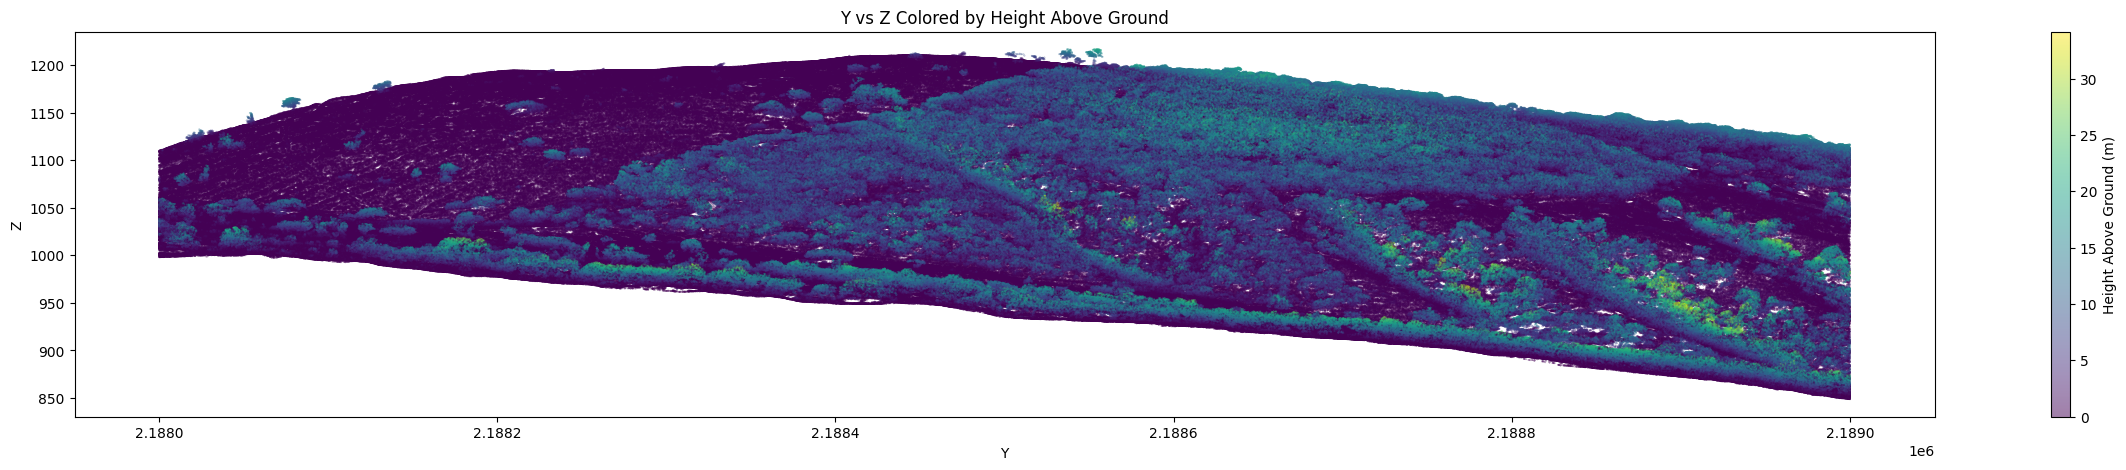

In [17]:
plot_2d(arrays[0], x_dim='Y', y_dim='Z', alpha=0.5, point_size=0.1, fig_size=(30, 5))

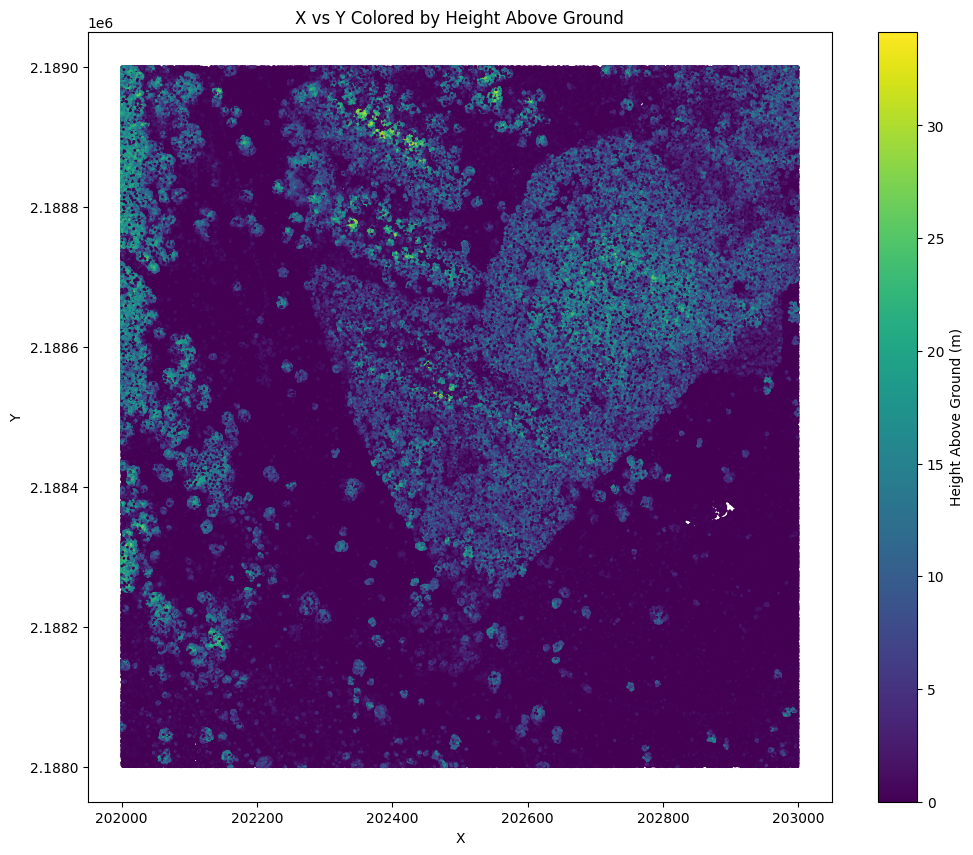

In [18]:
plot_2d(arrays[0], x_dim='X', y_dim='Y', fig_size=(12, 10))

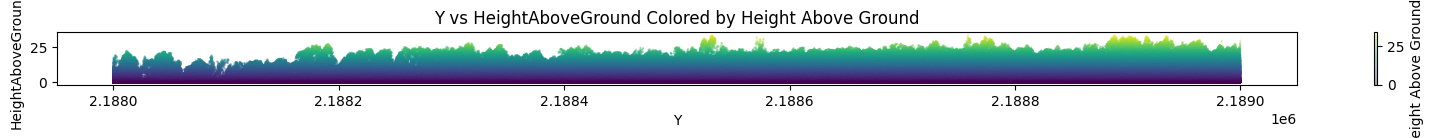

In [19]:
plot_2d(arrays[0], x_dim='Y', y_dim='HeightAboveGround', alpha=0.4, point_size=0.1)

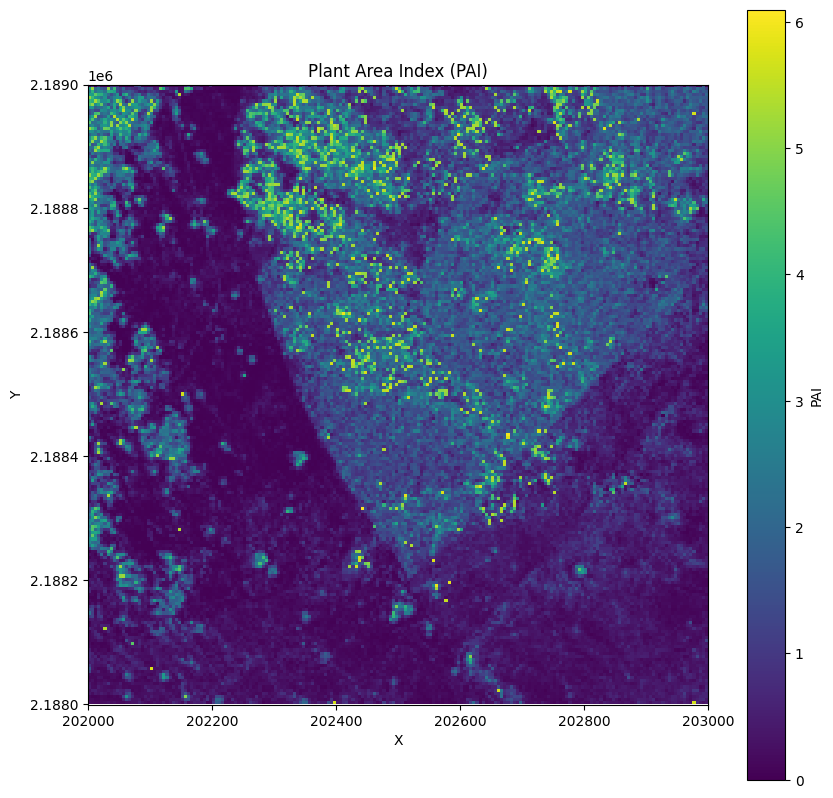

In [10]:
plot_pai(pai, extent, cmap='viridis', fig_size=None)

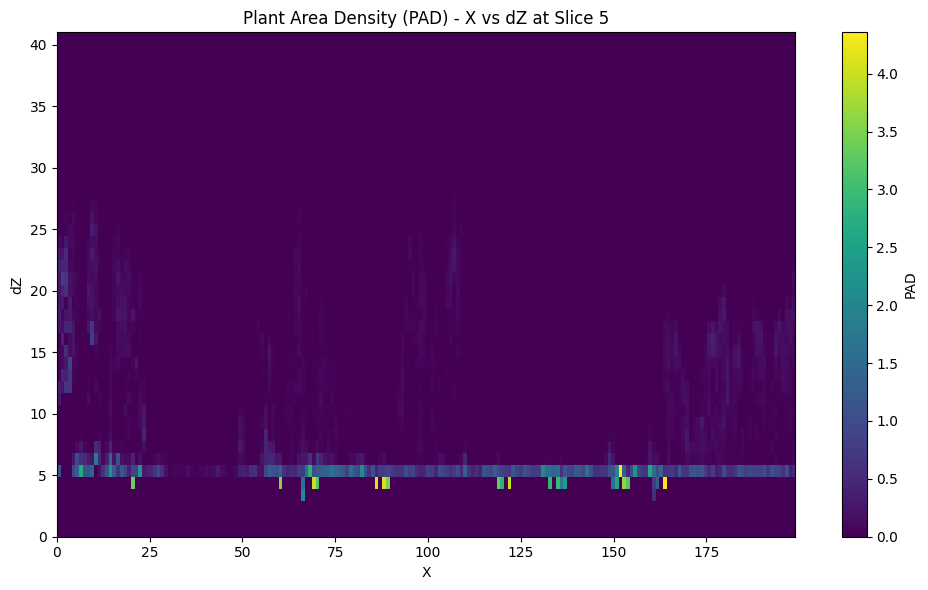

In [11]:
plot_pad_2d(pad, 5, axis='y', cmap='viridis')